## Import Library
Pada tahap ini, kita mengimpor semua library yang diperlukan untuk proyek ini.

In [1]:
pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


## Load Dataset
Tahap ini memuat dataset yang akan digunakan untuk analisis dan pemodelan. Dataset ini berisi data mahasiswa, termasuk informasi seperti status perkawinan, nilai masuk, performa akademik, dan status akhir (Dropout, Graduate, atau Enrolled).

In [3]:
# Load dataset
df = pd.read_csv('data.csv')
# Tampilkan 5 baris pertama
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666.666.666.666.600,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate


## Data Understanding
Pada tahap ini, kita melakukan eksplorasi awal untuk memahami dataset:  
- Melihat informasi dasar dataset, seperti tipe data dan jumlah entri non-null.  
- Melihat statistik deskriptif untuk kolom numerik, seperti rata-rata, minimum, dan maksimum.  
- Memeriksa apakah ada nilai yang hilang (missing values).  
- Menghitung distribusi kelas pada kolom target (`Status`).

In [4]:
# info dataset
df.info()

# statistik deskriptif
df.describe()

# cek missing values
df.isnull().sum()

# hitung frekuensi status
df['Status'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

Status
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

## Data Preparation
Pada tahap ini, data dipersiapkan melalui beberapa langkah berikut:

1. Pembersihan data :   
- Memperbaiki format kolom numerik yang salah (misalnya, banyak titik) dan mengubahnya ke float.  
- Mengisi nilai kosong (NaN) dengan median untuk data numerik dan modus untuk data kategorikal.

2. Pembuatan fitur baru : 
- Menambahkan fitur `academic_risk_1st_sem` dan `academic_risk_2nd_sem` untuk menggambarkan risiko akademik mahasiswa.

3. Encoding target : 
- Mengubah kolom `Status` menjadi label biner: 1 untuk Dropout, 0 untuk Graduate/Enrolled.

4. Encoding fitur kategorikal :
- Mengubah fitur kategorikal menjadi angka dengan `LabelEncoder`.

5. Pemisahan data  
- Memisahkan fitur dan target, lalu membagi data menjadi data latih dan data uji (80:20).


In [5]:
# Pembersihan data: Tangani nilai string yang salah diformat di semua kolom numerik
def clean_numeric_column(column):
    if df[column].dtype == 'object':  # Jika kolom berupa string
        # Ganti titik berlebih dengan format yang benar (misalnya, '11.666.666.666.666.600' menjadi '11666666666666')
        df[column] = df[column].str.replace('.', '', regex=False)  # Hapus semua titik
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Konversi ke numerik, ganti error dengan NaN

# Identifikasi kolom numerik yang seharusnya float/int tetapi terbaca sebagai object
numeric_cols = ['Admission_grade', 'Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_grade',
                'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_enrolled',
                'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_enrolled']
for col in numeric_cols:
    clean_numeric_column(col)

# Isi NaN yang dihasilkan dari konversi error dengan median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Pembersihan data tambahan: Tangani missing values
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        df[column] = df[column].fillna(df[column].median())
    else:
        df[column] = df[column].fillna(df[column].mode()[0])

# Feature Engineering
# Buat fitur baru: rasio approved/enrolled untuk semester 1 dan 2
df['academic_risk_1st_sem'] = df['Curricular_units_1st_sem_approved'] / df['Curricular_units_1st_sem_enrolled']
df['academic_risk_1st_sem'] = df['academic_risk_1st_sem'].fillna(0)  # Jika enrolled = 0
df['academic_risk_2nd_sem'] = df['Curricular_units_2nd_sem_approved'] / df['Curricular_units_2nd_sem_enrolled']
df['academic_risk_2nd_sem'] = df['academic_risk_2nd_sem'].fillna(0)  # Jika enrolled = 0

# Encode variabel kategorikal
# Ubah Status menjadi biner: Dropout (1) vs. Graduate/Enrolled (0)
df['Status_binary'] = df['Status'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Encode variabel kategorikal lainnya menggunakan LabelEncoder
le = LabelEncoder()
categorical_cols = ['Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance',
                   'Previous_qualification', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification',
                   'Mothers_occupation', 'Fathers_occupation', 'Gender']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Pisahkan fitur dan target
X = df.drop(['Status', 'Status_binary'], axis=1)
y = df['Status_binary']

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Exploratory Data Analysis (EDA)
EDA dilakukan untuk memahami pola dan hubungan dalam data. Pada tahap ini dilakukan:

- Visualisasi distribusi target (`Status`) menggunakan donut chart dan bar chart
- Visualisasi `Status` berdasarkan `Gender` untuk melihat perbedaan distribusi antar jenis kelamin
- Visualisasi `Status` berdasarkan `Scholarship_holder` untuk mengevaluasi pengaruh beasiswa terhadap status mahasiswa
- Visualisasi hubungan antara `Debtor` dan `Scholarship_holder`
- Visualisasi distribusi `Status` menggunakan countplot (bar chart vertikal)
- Heatmap korelasi antar fitur numerik untuk melihat hubungan antar variabel
- Boxplot `Admission_grade` terhadap `Status` untuk melihat pengaruh nilai masuk terhadap status mahasiswa



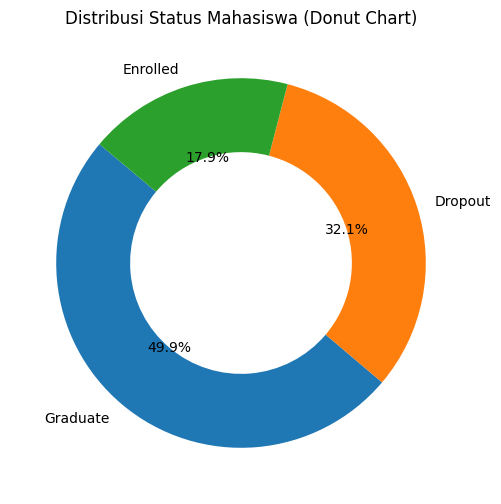

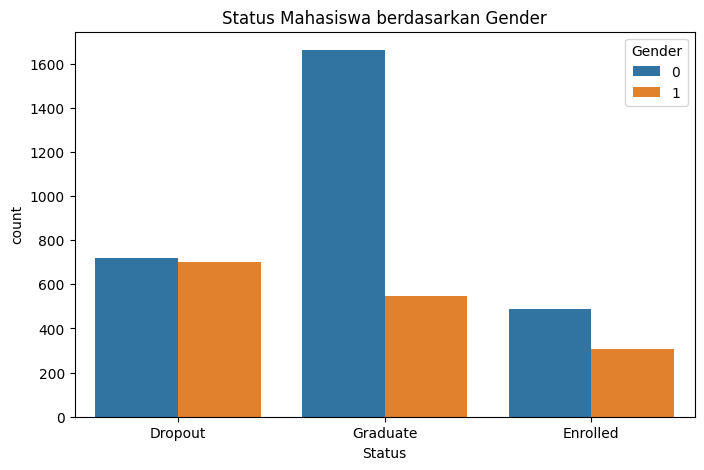

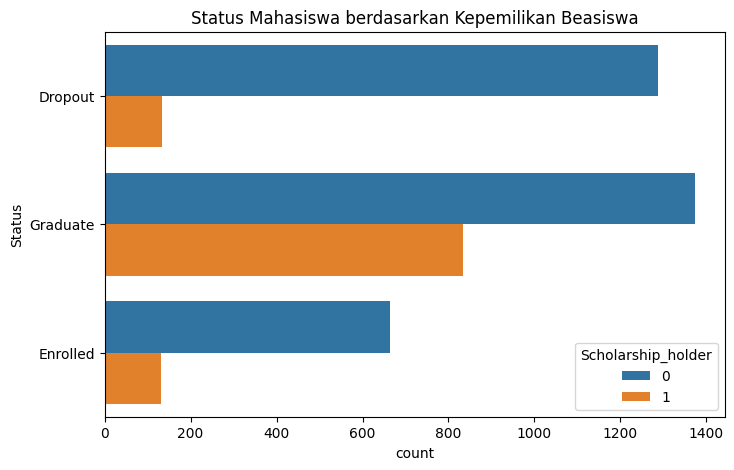

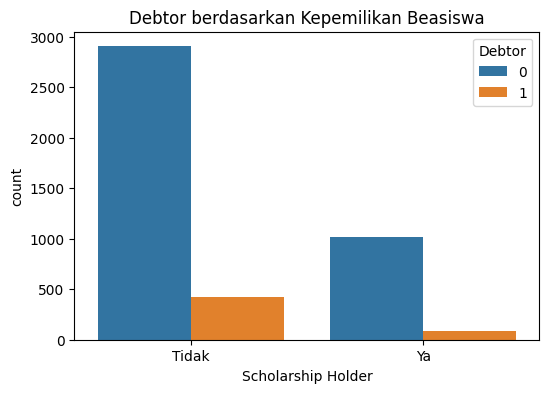

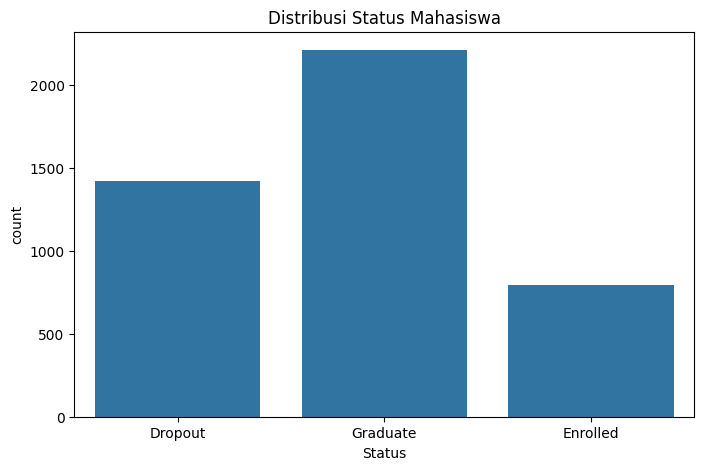

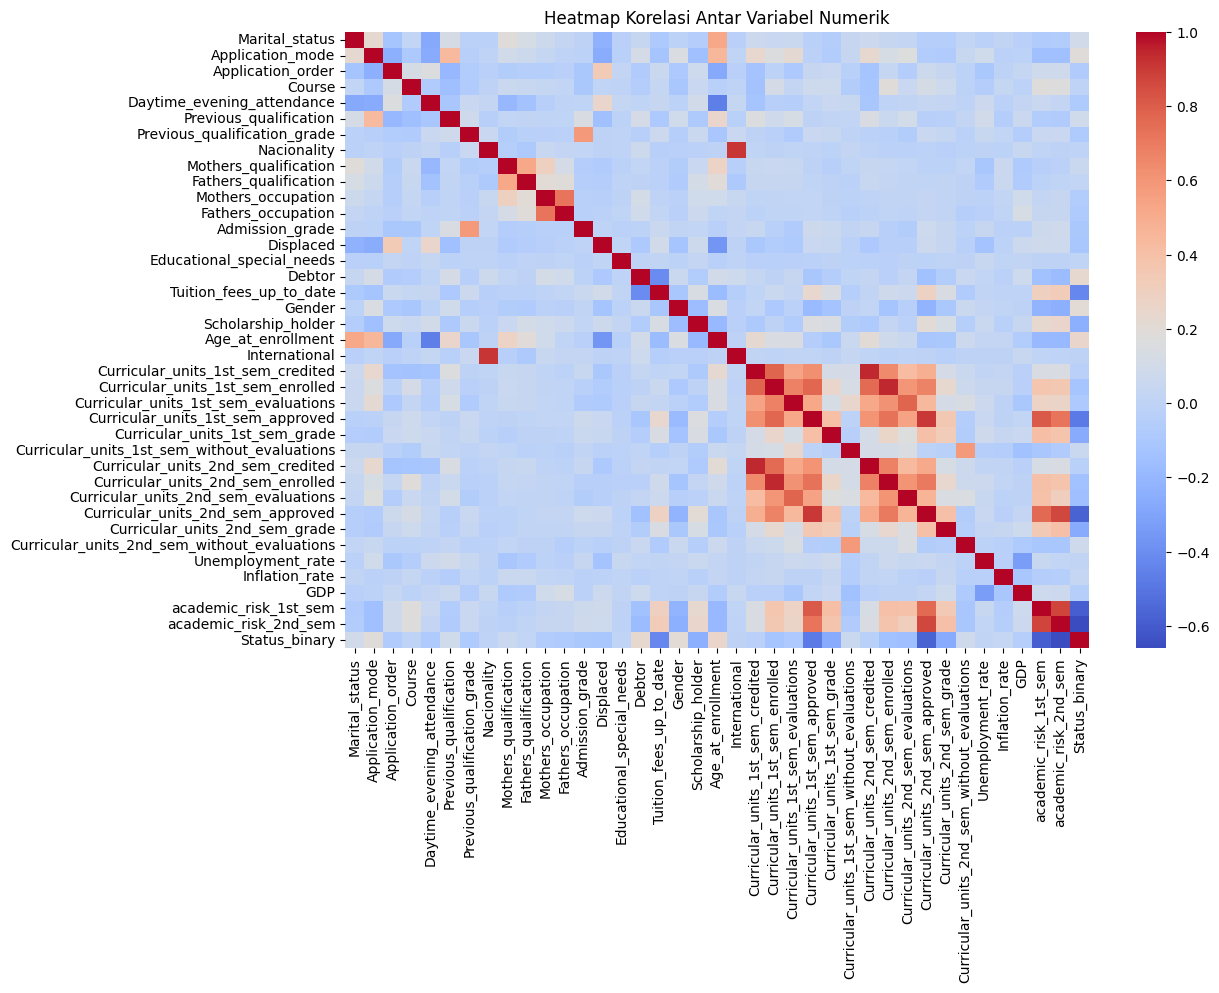

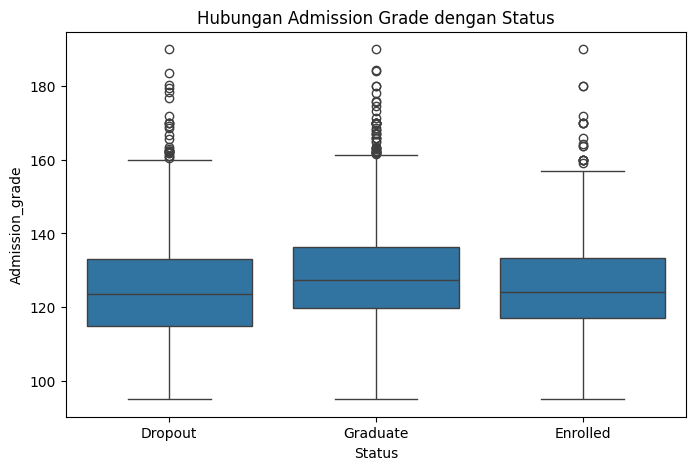

In [9]:

# Donut chart distribusi Status
plt.figure(figsize=(6, 6))
status_counts = df['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'width':0.4})
plt.title('Distribusi Status Mahasiswa (Donut Chart)')
plt.show()

# Visualisasi Status berdasarkan Gender
plt.figure(figsize=(8, 5))
sns.countplot(x='Status', hue='Gender', data=df)
plt.title('Status Mahasiswa berdasarkan Gender')
plt.show()

# Visualisasi Status berdasarkan Scholarship_holder
plt.figure(figsize=(8, 5))
sns.countplot(y='Status', hue='Scholarship_holder', data=df)
plt.title('Status Mahasiswa berdasarkan Kepemilikan Beasiswa')
plt.show()

# Visualisasi Debtor berdasarkan Scholarship_holder
plt.figure(figsize=(6, 4))
sns.countplot(x='Scholarship_holder', hue='Debtor', data=df)
plt.title('Debtor berdasarkan Kepemilikan Beasiswa')
plt.xlabel('Scholarship Holder')
plt.xticks([0, 1], ['Tidak', 'Ya'])
plt.show()

# Visualisasi distribusi target (Status)
plt.figure(figsize=(8, 5))
sns.countplot(x='Status', data=df)
plt.title('Distribusi Status Mahasiswa')
plt.show()

# Visualisasi korelasi antar variabel numerik
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()

# Visualisasi hubungan Admission_grade dengan Status
plt.figure(figsize=(8, 5))
sns.boxplot(x='Status', y='Admission_grade', data=df)
plt.title('Hubungan Admission Grade dengan Status')
plt.show()


## Modeling
Pada tahap ini, model Random Forest digunakan untuk melatih data yang telah diproses dan diuji menggunakan data pengujian.

In [7]:
# Inisialisasi dan latih model Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)


## Evaluation
Evaluasi dilakukan menggunakan data uji dengan beberapa metrik berikut :
- Confusion matrix  
- Classification report  
- Accuracy score  
- Visualisasi hasil evaluasi 


Confusion Matrix:
[[535  34]
 [ 87 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       569
           1       0.87      0.72      0.79       316

    accuracy                           0.86       885
   macro avg       0.87      0.83      0.84       885
weighted avg       0.86      0.86      0.86       885


Accuracy: 0.8633


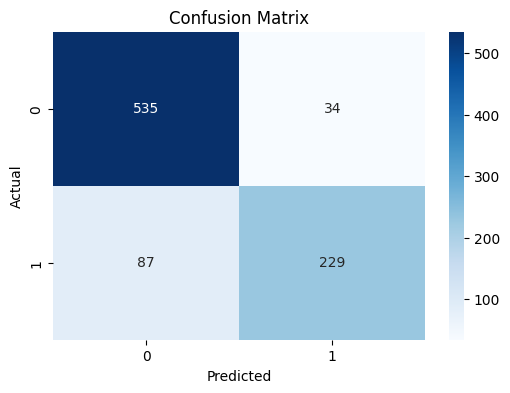

In [12]:
# Evaluasi model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cetak akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Export Dataset to SQLite

Dataset yang sudah diproses disimpan ke database SQLite dalam tabel `catatan_mahasiswa`.



In [13]:
# Ekspor dataset ke SQLite
conn = sqlite3.connect('data_mahasiswa.db')  # Buat atau hubungkan ke database SQLite
df.to_sql('catatan_mahasiswa', conn, if_exists='replace', index=False)  # Ekspor DataFrame ke tabel 'catatan_mahasiswa', timpa jika sudah ada
conn.close()  # Tutup koneksi database
print("\nDataset berhasil diekspor ke data_mahasiswa.db")



Dataset berhasil diekspor ke data_mahasiswa.db



## Save Model
Model disimpan ke file `model_dropout_prediction.pkl` untuk digunakan kembali tanpa perlu pelatihan ulang.

In [14]:
# Simpan model dan scaler
joblib.dump(model, 'model_dropout_prediction.pkl')
print("\nModel disimpan sebagai 'model_dropout_prediction.pkl'")


Model disimpan sebagai 'model_dropout_prediction.pkl'
